In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/pima-indians-diabetes-database/diabetes.csv


### 1. Read in the data

In [4]:
diabetes_df = pd.read_csv('/kaggle/input/pima-indians-diabetes-database/diabetes.csv')
diabetes_df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### 2. Explore and vizualize the data

In [5]:
diabetes_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [6]:
diabetes_df.isna().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

array([[<AxesSubplot:title={'center':'Pregnancies'}>,
        <AxesSubplot:title={'center':'Glucose'}>,
        <AxesSubplot:title={'center':'BloodPressure'}>],
       [<AxesSubplot:title={'center':'SkinThickness'}>,
        <AxesSubplot:title={'center':'Insulin'}>,
        <AxesSubplot:title={'center':'BMI'}>],
       [<AxesSubplot:title={'center':'DiabetesPedigreeFunction'}>,
        <AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Outcome'}>]], dtype=object)

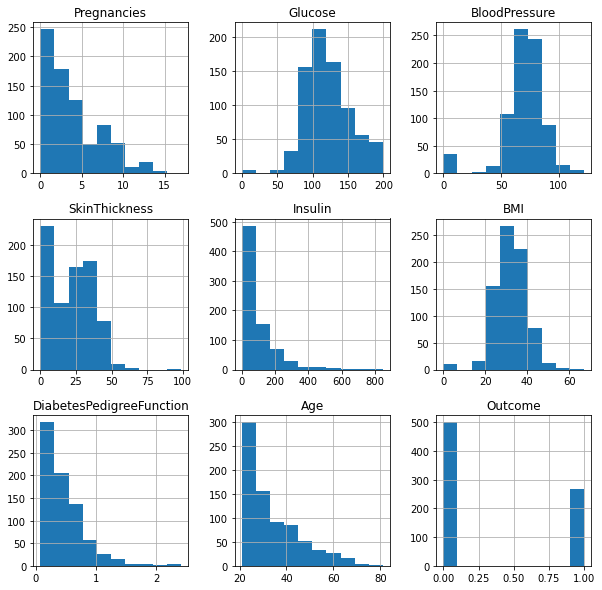

In [7]:
diabetes_df.hist(figsize=(10, 10))

In [8]:
diabetes_df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [9]:
diabetes_df.duplicated().sum()

0

- There are many columns that contain various 0 values; these are likely NaN and should be replaced
- Pregnancies and Outcome with values of zero should be kept

In [10]:
import numpy as np
replace_cols = [col for col in diabetes_df.columns if not(col == 'Outcome' or col == 'Pregnancies')]

diabetes_df[replace_cols] = diabetes_df[replace_cols].replace({0: np.nan})

diabetes_df.isna().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

- Given NaN values, impute the median value using SimpleImputer
- Add this to the pipeline later to avoid test-train leakage

In [11]:
from sklearn.impute import SimpleImputer

median_imputer = SimpleImputer(strategy='median')

- Factors that are commonly known to be associated with diabetes occur in adults who have type 2 diabetes
- Type 1 diabetes may occur in kids and the causes are still unknown
- Adults with a certain combinations of factors (like obesity or family history) are more likely to develop T2D
- Family history also affects T1D
- The diabetes pedigree function takes family history into account

Text(0.5, 1.0, 'Frequency of age in the dataset')

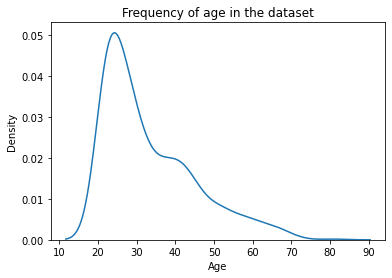

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# specifically check the age distribution
ax = sns.kdeplot(data=diabetes_df, x='Age')
ax.set_title('Frequency of age in the dataset')

In [55]:
def numerical_v_outcome(y, ax, graph_type='violin', title=None, df=diabetes_df):
    if title == None:
        title = f'{y} vs Outcome'
    if graph_type == "violin":
        ax = sns.violinplot(data=df, x='Outcome', y=y, ax=ax)
    else:
        ax = sns.boxplot(data=df, x='Outcome', y=y, ax=ax)
    ax.set_title(title)
    return ax

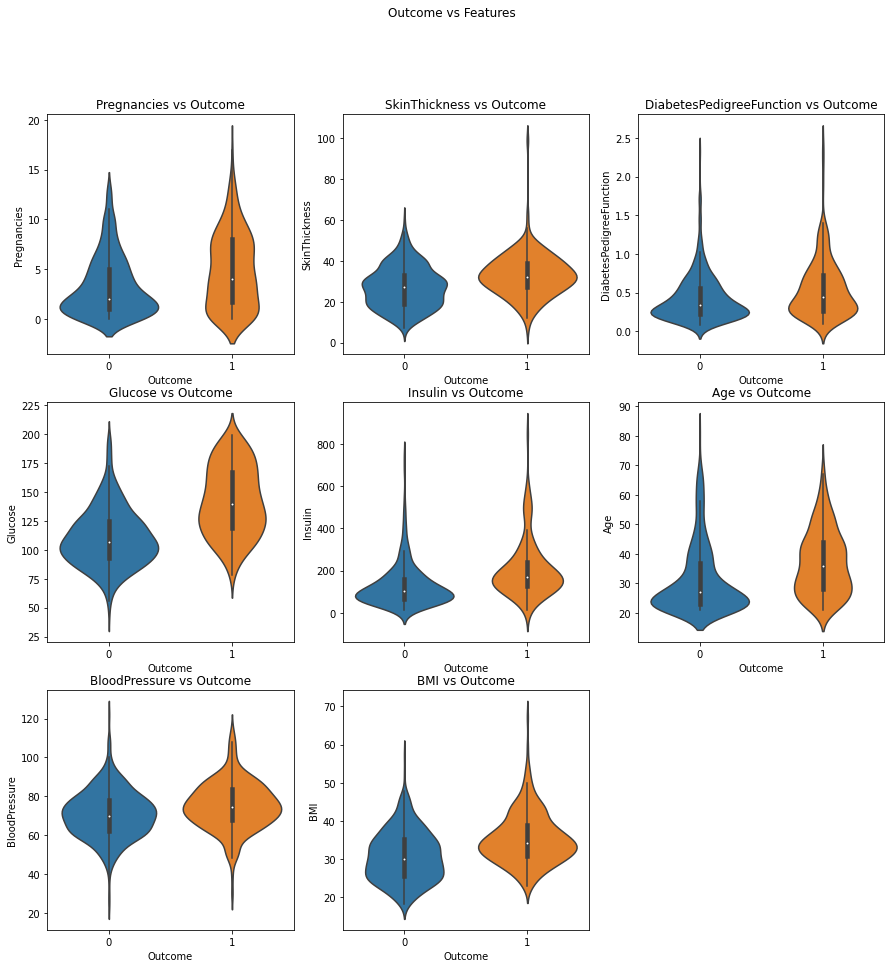

In [53]:
# plot various factors vs the outcome with a violin plot to see the frequency of distribution
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
index_1 = 0
index_2 = 0
fig.suptitle('Outcome vs Features')

for i in range(len(diabetes_df.columns)):
    if diabetes_df.columns[i] != "Outcome":
        numerical_v_outcome(diabetes_df.columns[i], axes[index_1, index_2])
    else:
        fig.delaxes(axes[index_1, index_2])
    index_1 += 1
    if index_1 == 3:
        index_1 = 0
        index_2 += 1

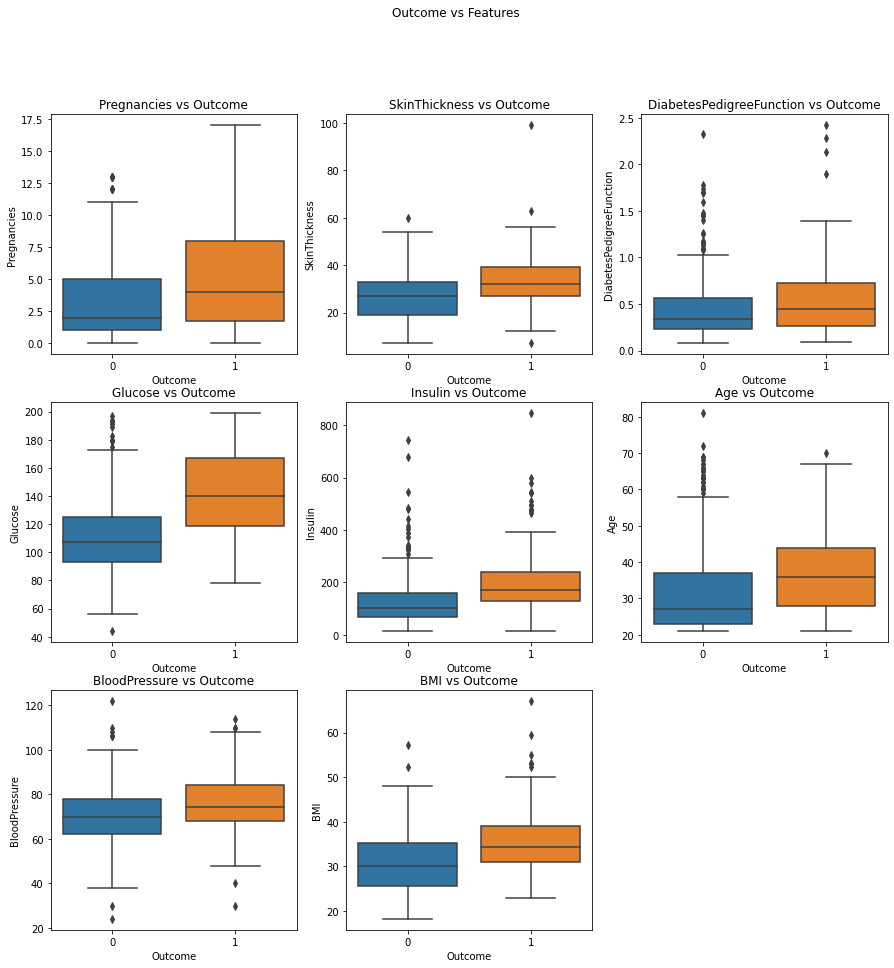

In [56]:
# plot various factors vs the outcome showing the points to spot outliers
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
index_1 = 0
index_2 = 0
fig.suptitle('Outcome vs Features')

for i in range(len(diabetes_df.columns)):
    if diabetes_df.columns[i] != "Outcome":
        numerical_v_outcome(diabetes_df.columns[i], axes[index_1, index_2], graph_type='boxplot')
    else:
        fig.delaxes(axes[index_1, index_2])
    index_1 += 1
    if index_1 == 3:
        index_1 = 0
        index_2 += 1

- By comparing the graphs, it is evident that blood glucose, age, and BMI mark visible differences
- The diabetes pedigree function is surprisingly not as useful as I would have expected it to be
- Many of the graphs also have outliers in the upper ranges so it would be good to scale those values into more normal ranges to not overfit the model